In [37]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import time      as tim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# Parameters
# mesh_path = '/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= 6
which_mode= 'dmoc_tseries'

#_____________________________________________________________________________________
input_paths= list()
input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.3/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_orig_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne09_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_nycander05_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_stormtide2_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne09_ck0.3/')
# input_paths.append('/home/ollie/pscholz/results/old_trr181_tke+idemix_nycander05_ck0.3/')
# input_paths.append('/home/ollie/pscholz/results/old_trr181_tke+idemix_stormtide2_ck0.3/')

input_names= list()
input_names.append('TKE, ck=0.1')
# input_names.append('TKE, ck=0.3')
# input_names.append('TKE+IDEMIX, ck=0.1, jayne (old param)')
# input_names.append('TKE+IDEMIX, ck=0.1, jayne (new param)')
# input_names.append('TKE+IDEMIX, ck=0.1, nycander (new param)')
# input_names.append('TKE+IDEMIX, ck=0.1, stormtide (new param)')
# input_names.append('TKE+IDEMIX, ck=0.3, jayne (new param)')
# input_names.append('TKE+IDEMIX, ck=0.3, nycander (new param)')
# input_names.append('TKE+IDEMIX, ck=0.3, stormtide (new param)')

vname     = 'amoc'
# year      = [1979,2019]
year      = [1958,2019]
mon, day, record, box, depth = None, None, None, None, None
#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac = None, None, None, None

#_____________________________________________________________________________________
do_rescale= None
ncolumn   = 3 
do_allcycl= False
which_dpi = 300
which_lat = 26.5 #'max' # 'max', 26.0
which_transf = 'dmoc'
do_zcoord = False
do_rapid  = False

In [39]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if which_cycl is not None: 
    #__________________________________________________________________________________________________
    if do_allcycl: cycl_s=1
    else         : cycl_s=which_cycl    
    
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, which_cycl+1):
            # input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if ref_path is not None:
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, which_cycl+1):
            #ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)    
    
#______________________________________________________________________________________________________        
cinfo=dict({'cstr':cstr, 'cnum':cnum}) 
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac   
if ref_path is not None: cinfo['cref'  ]=0.0    
    
#______________________________________________________________________________________________________
# in case of diff plots
if ref_path is not None:
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record  
        
#______________________________________________________________________________________________________
if not isinstance(which_lat, list): which_lat = list([which_lat])        
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if ref_path is not None: 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names
        
#______________________________________________________________________________________________________
if not isinstance(which_lat[0], float) and not isinstance(which_lat[0], int): do_rapid=False
else:    
    if np.abs(which_lat[0]-26.5)>1.0: do_rapid=False

 > found *.pckl file: /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
0 /home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/6/ TKE, ck=0.1


In [40]:
# define density levels 
# original dima
# std_dens=[0.0000,   30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
# 32.77778, 33.01000, 33.33333, 33.56000, 33.88889, 34.11000, 34.44444, 34.62000, 35.00000,
# 35.05000, 35.10622, 35.20319, 35.29239, 35.37498, 35.41300, 35.45187, 35.52380, 35.59136,
# 35.65506, 35.71531, 35.77247, 35.82685, 35.87869, 35.92823, 35.97566, 35.98000, 36.02115,
# 36.06487, 36.10692, 36.14746, 36.18656, 36.22434, 36.26089, 36.29626, 36.33056, 36.36383,
# 36.39613, 36.42753, 36.45806, 36.48778, 36.51674, 36.54495, 36.57246, 36.59500, 36.59932,
# 36.62555, 36.65117, 36.67621, 36.68000, 36.70071, 36.72467, 36.74813, 36.75200, 36.77111,
# 36.79363, 36.81570, 36.83733, 36.85857, 36.87500, 36.87940, 36.89985, 36.91993, 36.93965,
# 36.95904, 36.97808, 36.99682, 37.01524, 37.03336, 37.05119, 37.06874, 37.08602, 37.10303,
# 37.11979, 37.13630, 37.15257, 37.16861, 37.18441, 37.50000, 37.75000, 40.00000]

# my density layers 2nd try
std_dens=[ 0.00000, 29.50000, 30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
          32.77778, 33.01000, 33.33333, 33.56000, 33.78170, 33.79659, 33.81331, 33.83206, 33.85258, 33.87502,
          33.88889, 33.90019, 33.92843, 33.96012, 33.99567, 34.03267, 34.07050, 34.11295, 34.16058, 34.21400,
          34.27274, 34.33865, 34.41114, 34.47728, 34.55149, 34.62872, 34.71458, 34.81014, 34.91325, 35.02337,
          35.13865, 35.25518, 35.37026, 35.48624, 35.58763, 35.67886, 35.76112, 35.82097, 35.87630, 35.92691,
          35.97247, 36.02033, 36.06813, 36.11950, 36.17459, 36.23291, 36.29566, 36.36239, 36.43058, 36.50178,
          36.57474, 36.64730, 36.71590, 36.77414, 36.82096, 36.85908, 36.89139, 36.91962, 36.94532, 36.96900,
          36.98623, 37.00269, 37.01746, 37.03056, 37.04018, 37.05134, 37.06372, 37.07111, 37.10000, 37.25556,
          37.41111, 37.56667, 37.72222, 37.87778, 38.03333, 38.18889, 38.34444, 38.50000, 40.00000]


In [41]:
# moctseries_list = list()
# year_list       = list(range(year[0], year[1]+1))
# time            = np.array(year_list)
# nt              = time.size
# for datapath, descript in zip(input_paths, input_names): 
#     print(datapath, descript)
    
#     # allocate dmoc timeseries 
#     dmoc_t = np.zeros((nt, len(which_lat)))
#     print(' > year:|', end='')
#     ts = tim.time()
    
#     # compute dmoc for every year separate, otherwise matrices become to big and you run out of memory !!!
#     # otherwise you need to chunk the time dimension --> this would increase the speed a bit --> but depends 
#     # on how much memory is available --> this here is the variant with the least memory demand
#     for nti, year_i in enumerate(year_list): 
#         print('{:d}|'.format(year_i), end='')
#         if np.mod(nti+1,10)==0: print('',end='\n        |')
#         #____________________________________________________________________________________________________
#         # load DMOC std_* data --> combined in xarray dataset
#         data_dmoc = tpv.load_dmoc_data(mesh, datapath, descript, year_i, which_transf, std_dens, do_info=False, do_tarithm='mean') 

#         #____________________________________________________________________________________________________
#         # compute moc profile over time
#         dmoc      = tpv.calc_dmoc(mesh, data_dmoc, dlat=1.0, which_moc=vname, do_info=False)
    
#         #____________________________________________________________________________________________________
#         # compute time-series
#         # look for maximum value below 500m at certain latitude or between latitudinal range 'max' 
#         # (looks between 30°N and 45°N)
#         for nli, lat in enumerate(which_lat):
#             if lat=='max': dmoc_t[nti, nli]= dmoc['dmoc'].isel(nlat=(dmoc['nlat']>=45) & (dmoc['nlat']<=60)).max().values
#             else         : dmoc_t[nti, nli]= dmoc['dmoc'].isel(nlat=np.where(dmoc['nlat'].values>=lat)[0][0] ).max().values
        
#         #____________________________________________________________________________________________________
#         del(data_dmoc, dmoc)
        
#     #____________________________________________________________________________________________________
#     # moctseries_list.append([time, moc_t])    
#     moctseries_list.append(dmoc_t)    
#     print('\n        elapsed time: {:3.2f}min.'.format((tim.time()-ts)/60.0))
#     del(dmoc_t)

In [42]:
moctseries_list = list()
year_list       = list(range(year[0], year[1]+1))
chnk_size       = 5 # compute dmoc time-series in chunks of chnk_size years
chnk_yrs_list   = year_list[::chnk_size]

time            = np.array(year_list)
nt              = time.size
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    
    # allocate dmoc timeseries 
    dmoc_t = np.zeros((nt, len(which_lat)))
    print(' > year:', end='')
    ts = tim.time()
    
    # compute dmoc time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
    # you can play with chnk_size for the case you run out of memory 
    for nchnk, year_s in enumerate(chnk_yrs_list): 
        year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
        print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='\n        ')
         
        #____________________________________________________________________________________________________
        # load DMOC std_* data --> combined in xarray dataset
        data_dmoc = tpv.load_dmoc_data(mesh, datapath, descript, year_chnk, which_transf, std_dens, do_info=False, do_tarithm=None) 

        #____________________________________________________________________________________________________
        # compute moc profile over time
        dmoc      = tpv.calc_dmoc(mesh, data_dmoc, dlat=1.0, which_moc=vname, do_info=False)
    
        #____________________________________________________________________________________________________
        # compute time-series
        # (looks between 45°N and 60°N when which_lat='max', or at latitude) 
        nt_chnk = dmoc['time'].values.size
        for nti in range(nt_chnk):
            dmoc_d=dmoc.isel(time=nti).copy()
            for nli, lat in enumerate(which_lat):
                if lat=='max': dmoc_t[(nchnk*chnk_size)+nti, nli]= dmoc_d['dmoc'].isel(nlat=(dmoc_d['nlat']>=45) & (dmoc_d['nlat']<=60)).max().values
                else         : dmoc_t[(nchnk*chnk_size)+nti, nli]= dmoc_d['dmoc'].isel(nlat=np.where(dmoc_d['nlat'].values>=lat)[0][0] ).max().values
        
        #____________________________________________________________________________________________________
        del(data_dmoc, dmoc)
        
    #____________________________________________________________________________________________________
    # moctseries_list.append([time, moc_t])    
    moctseries_list.append(dmoc_t)    
    print('        elapsed time: {:3.2f}min.'.format((tim.time()-ts)/60.0))
    del(dmoc_t)

/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/6/ TKE, ck=0.1
 > year:1958|1959|1960|1961|1962
        1963|1964|1965|1966|1967
        1968|1969|1970|1971|1972
        1973|1974|1975|1976|1977
        1978|1979|1980|1981|1982
        1983|1984|1985|1986|1987
        1988|1989|1990|1991|1992
        1993|1994|1995|1996|1997
        1998|1999|2000|2001|2002
        2003|2004|2005|2006|2007
        2008|2009|2010|2011|2012
        2013|2014|2015|2016|2017
        2018|2019
                elapsed time: 2.43min.


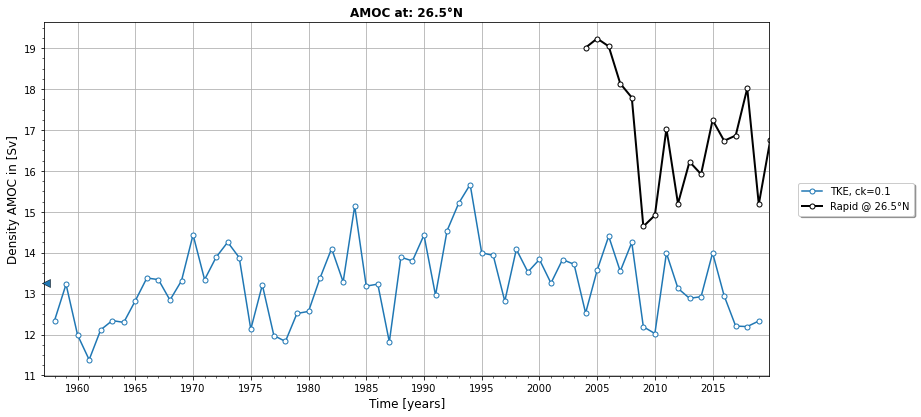

In [43]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
if which_lat[0]=='max': slabel='max{:s}_@_45N<=lat<=60N'.format(vname.upper(),which_lat[0])
else                  : slabel='{:s}_@_{:2.1f}N'.format(vname.upper(),which_lat[0])
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
if save_fname is not None: spath = save_fname
path_rapid = None    
if do_rapid: path_rapid=os.path.join('/home/ollie/pscholz/tripyview_github/data/data_RAPID26.5','moc_transports.nc')
    
fig,ax=tpv.plot_dmoc_tseries(time, moctseries_list, input_names, which_lat=which_lat, which_moc=vname, 
                              which_cycl=which_cycl, do_allcycl=do_allcycl, do_rapid=path_rapid, 
                              do_save=spath, save_dpi=which_dpi, )  